In [13]:
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')
import cv2

from skimage import color, io, exposure, feature, filters, measure
from skimage.filters import threshold_otsu, gaussian_filter
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

import numpy as np
from numpy import cos, sin, conjugate, sqrt

from math import atan2

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 9

In [3]:
img = io.imread('2.tiff')
gray = color.rgb2gray(img)
hsv = color.rgb2hsv(img)

### Over-segment the image using kmeans on 5 dimensional space

In [73]:
segments_slic = slic(img, n_segments=500, compactness=10, sigma=1, convert2lab = True)
segments_slic = segments_slic + 1  # So that no labelled region is 0 and ignored by regionprops
regions = measure.regionprops(segments_slic)

#### Our first feature is the ( intra-superpixel variance ) * ( average intensity level )
We first extract the saturation channel of the image and run gaussian filter to smoothen the image. Histogram Equalization is performed. For every superpixel found for the original image, we find the variance in the intensity levels of the processed saturation channel and multiply with the mean. This gives a feature of each superpixel.

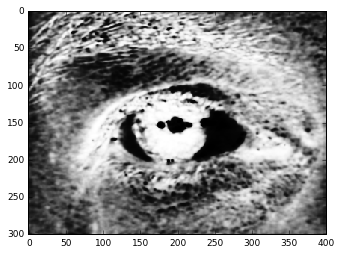

In [111]:
sat = hsv[:,:,1]
sat = gaussian_filter(sat, 1)
sat = exposure.equalize_hist(sat)
io.imshow(sat)

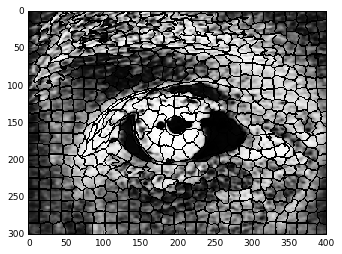

In [112]:
io.imshow(mark_boundaries(sat, segments_slic,[0,0,0]))

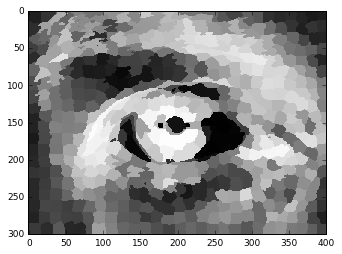

In [113]:
sat_avg_labeled = color.label2rgb(segments_slic, sat, kind='avg')
io.imshow(sat_avg_labeled)

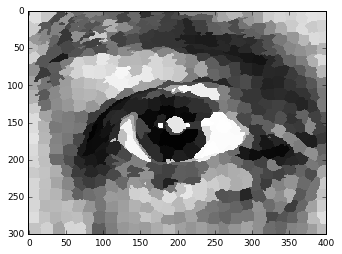

In [114]:
def mean_var_feature(sat_img, segmented_regions, visualization = False):
    features = np.zeros(len(segmented_regions),np.float64)
    count = 0
    if visualization:
        visual = np.zeros(sat_img.shape, np.float64)
    for region in segmented_regions:
        I = [sat[i[0]][i[1]] for i in region['coords']]
        m = np.mean(I)
        v = np.var(I)
        v = v + m# The coefficient 5 is ad-hoc. Should think of a better way
        
        features[count] =  1 - v if v <=1 else 0
        if visualization:
            for i in region['coords']:
                visual[i[0]][i[1]] = features[count] 
        count +=1
    if visualization:
        return features, visual
    else:
        return features
f, v = mean_var_feature(sat, regions, True)
io.imshow(v)

### Otsu Thresholding on Saturation Channel of the HSV image

In [16]:
thresh = threshold_otsu(sat)
binary = sat > 0.1

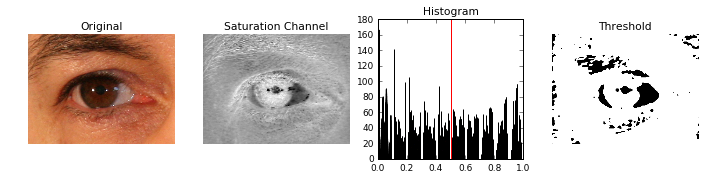

In [17]:
fig1 = plt.figure(figsize=(12, 2.5))
ax1 = plt.subplot(1, 4, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 4, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 4, 3)
ax4 = plt.subplot(1, 4, 4, sharex=ax1, sharey=ax1, adjustable='box-forced')

ax1.imshow(img)
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(hsv[:,:,1], cmap=plt.cm.gray)
ax2.set_title('Saturation Channel')
ax2.axis('off')

ax3.hist(sat)
ax3.set_title('Histogram')
ax3.axvline(thresh, color='r')

ax4.imshow(binary, cmap=plt.cm.gray)
ax4.set_title('Threshold')
ax4.axis('off')


plt.show()

### Cr - Cb in YCrCb image

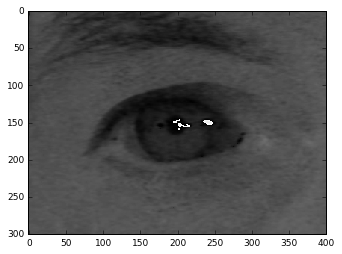

In [5]:
img = io.imread('2.tiff')
imgYCC = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
io.imshow(imgYCC[:,:,1] - imgYCC[:,:,2])

### 2R - G - B in RGB

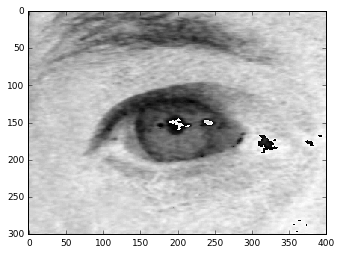

In [6]:
io.imshow(2*img[:,:,0] - img[:,:,1] -img[:,:,2])

### Edge Detector

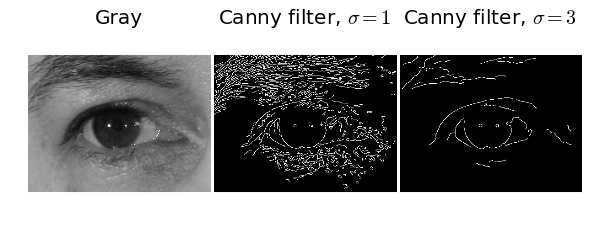

In [7]:
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(gray)
edges2 = feature.canny(gray, sigma=2.5)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(gray, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Gray', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9,
                    bottom=0.02, left=0.02, right=0.98)

plt.show()

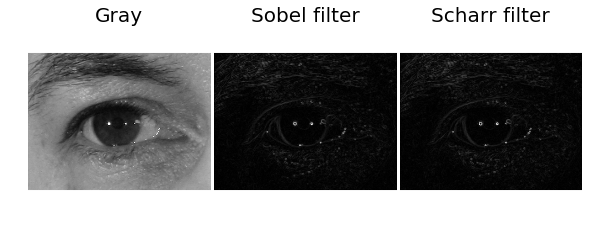

In [8]:
# Compute the Canny filter for two values of sigma
sobel1 = filters.sobel(gray)
scharr1 = filters.scharr(gray)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(gray, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Gray', fontsize=20)

ax2.imshow(sobel1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Sobel filter', fontsize=20)

ax3.imshow(scharr1, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Scharr filter', fontsize=20)

fig.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9,
                    bottom=0.02, left=0.02, right=0.98)

plt.show()

### HoG 

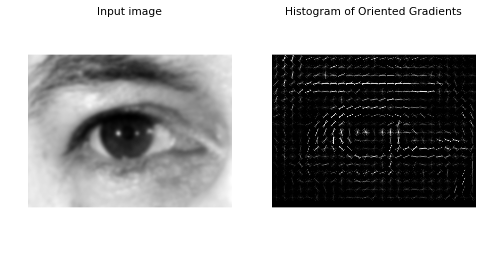

In [9]:
blur_gray = gaussian_filter(gray, 3)
fd, hog_image = feature.hog(blur_gray, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(blur_gray, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.015))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()


In [10]:
def _slow_zernike_poly(Y,X,n,l):
    def _polar(r,theta):
        x = r * cos(theta)
        y = r * sin(theta)
        return 1.*x+1.j*y

    def _factorial(n):
        if n == 0: return 1.
        return n * _factorial(n - 1)
    y,x = Y[0],X[0]
    vxy = np.zeros(Y.size, dtype=complex)
    index = 0
    for x,y in zip(X,Y):
        Vnl = 0.
        for m in range( int( (n-l)//2 ) + 1 ):
            Vnl += (-1.)**m * _factorial(n-m) /  \
                ( _factorial(m) * _factorial((n - 2*m + l) // 2) * _factorial((n - 2*m - l) // 2) ) * \
                ( sqrt(x*x + y*y)**(n - 2*m) * _polar(1.0, l*atan2(y,x)) )
        vxy[index] = Vnl
        index = index + 1

    return vxy

In [11]:
def zernike_reconstruct(img, radius, D, cof):

    idx = np.ones(img.shape)

    cofy,cofx = cof
    cofy = float(cofy)
    cofx = float(cofx)
    radius = float(radius)    

    Y,X = np.where(idx > 0)
    P = img[Y,X].ravel()
    Yn = ( (Y -cofy)/radius).ravel()
    Xn = ( (X -cofx)/radius).ravel()

    k = (np.sqrt(Xn**2 + Yn**2) <= 1.)
    frac_center = np.array(P[k], np.double)
    Yn = Yn[k]
    Xn = Xn[k]
    frac_center = frac_center.ravel()

    # in the discrete case, the normalization factor is not pi but the number of pixels within the unit disk
    npix = float(frac_center.size)

    reconstr = np.zeros(img.size, dtype=complex)
    accum = np.zeros(Yn.size, dtype=complex)

    for n in range(D+1):
        for l in range(n+1):
            if (n-l)%2 == 0:
                # get the zernike polynomial
                vxy = _slow_zernike_poly(Yn, Xn, float(n), float(l))
                # project the image onto the polynomial and calculate the moment
                a = sum(frac_center * conjugate(vxy)) * (n + 1)/npix
                # reconstruct
                accum += a * vxy
    reconstr[k] = accum
    return reconstr

In [12]:
D = 12
img = gray
rows, cols = img.shape
radius = cols//2 if rows > cols else rows//2
reconst = zernike_reconstruct(img, radius, D, (rows/2., cols/2.))

reconst = reconst.reshape(img.shape)


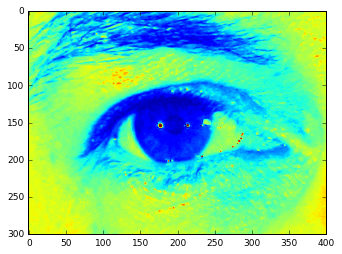

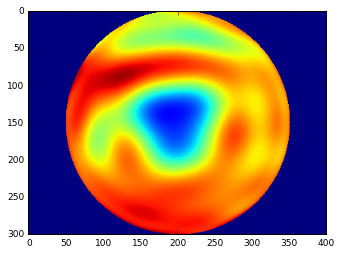

In [13]:
plt.figure(1)
plt.imshow(img, cmap=plt.cm.jet, origin = 'upper')
plt.figure(2)    
plt.imshow(reconst.real, cmap=plt.cm.jet, origin = 'upper')

In [103]:
print 0.5 if 0.9+0.4 <= 1 else 1

1
